# $k$ Means Clustering
## Foundations of Machine Learning
## `! git clone https://www.github.com/DS3001/kmc`

In [1]:
! git clone https://www.github.com/DS3001/kmc

Cloning into 'kmc'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 22 (delta 3), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (22/22), 4.68 MiB | 12.44 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Clustering
- The $k$NN algorithm provided a simple tool for *regression* --- predicting numeric values for new data from existing data --- and *classification* --- predicting categorical values for new data from existing data
- That kind of algorithm is called a *supervised learning* algorithm, because we are telling the machine that success
- Today we are going to look at an *unsupervised learning* algorithm, in which we ask the machine to look for general patterns, without defining what success looks like in advance

## Unsupervised Learning
- Basically, we don't have a $y$ --- there's no single "outcome" that we are specifically trying to predict, like with regression or classification (supervised learning)
- Instead, we have data and are looking for meaningful patterns that we can use to conceptualize relationships between the variables in general
- Presumably, there is a *latent structure* hidden with a categorical, discrete flavor in the data we are trying to recover

## Examples
- There are collusive bidders and competitive bidders in an auction, and we're trying to detect which are which by observing aspects of their behavior besides just the bid
- Many diseases (cancer, diabetes, etc.) have common underlying causes, but qualitatively different consequences from which different strains can be identified
- When looking for anomalies in data (cybersecurity, fraud, auditing), clustering can separate extreme cases from common ones and identify patterns of behavior that arouse suspicion (e.g. Benford's Law and cheating)

In [3]:
## Generate toy data:
np.random.seed(100) # Set the seed for replicability
N = 24  # Number of points
scale = .4  # Standard deviation of the shocks
noise = 1

# Generate (y,x1,x2) triples:
X1 = np.array([np.random.normal(1,scale,N),np.random.normal(1,scale,N)])
y1 = np.sum(X1,axis=0)/2+np.random.normal(0,noise,N)
X2 = np.array([np.random.normal(3,scale,N),np.random.normal(2,scale,N)])
y2 = np.sum(X2,axis=0)/2+np.random.normal(0,noise,N)
X3 = np.array([np.random.normal(5,scale,N),np.random.normal(3,scale,N)])
y3 = np.sum(X3,axis=0)/2+np.random.normal(0,noise,N)

gdf1 = pd.DataFrame({'y':y1,'x1':X1[0,:],'x2':X1[1,:],'g':'a'}) # Circles
gdf2 = pd.DataFrame({'y':y2,'x1':X2[0,:],'x2':X2[1,:],'g':'b'}) # Crosses
gdf3 = pd.DataFrame({'y':y2,'x1':X3[0,:],'x2':X3[1,:],'g':'c'}) # Squares
gdf = pd.concat([gdf1,gdf2,gdf3],axis=0) # Combine all data into one dataframe

gdf.head()

,y,x1,x2,g
0,-0.926628,0.300094,1.073807,a
1,2.726666,1.137072,1.374833,a
2,0.188790,1.461214,1.292400,a
3,0.672078,0.899026,1.544622,a
4,0.190970,1.392528,0.869505,a


## With Labels:
- This is the "true" labelling of the data:

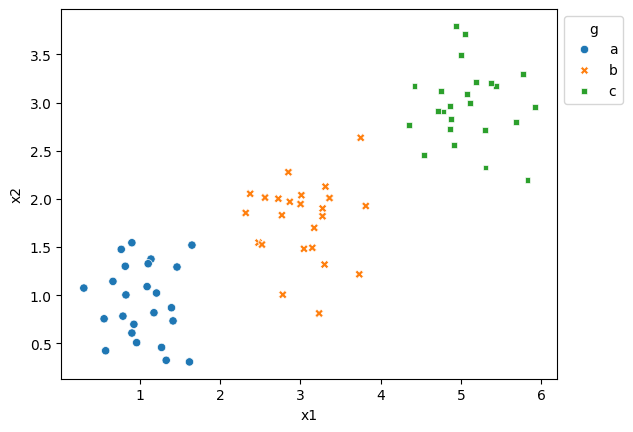

In [4]:
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='g',style='g') # Plot the fake data
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

## Without Labels:
- If the circle/square/dot shape and a/b/c color information is wiped away, some patterns still remain:

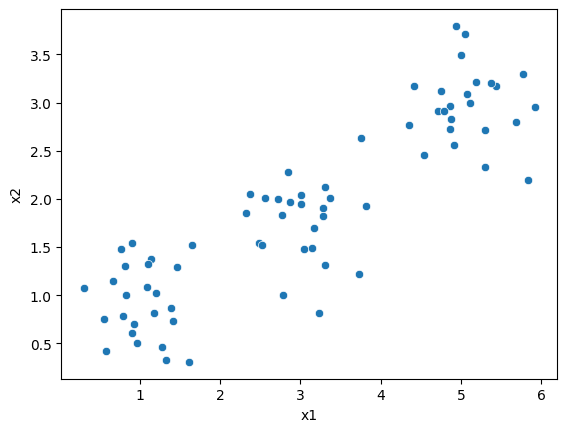

In [5]:
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2') # Plot the fake data

## Unsupervised Learning
- Basically: "Can we recover the labels by examining the data, without knowing which group a point belongs to?"
- This is a simple problem, but it is a prototype for more general issues in recovering unobserved heterogeneity among observational units
- We'll be motivated by a simple idea, similar to $k$NN: "If two points were created by the same data generating process, then their values are probably close together. If there are a discrete number of distinct data generating processes, we should be able to separate out their values from one another."

## $k$-Means Clustering Algorithm ($k$MC)
- The $k$-Means Clustering algorithm is:
  0. (Initialization) Randomly select $k$ points to be the *centroids*, $\{c_1, c_2, ..., c_k\}$
  1. Find the distance of each observation $x_i$ to each centroid $c_j$
  2. Assign each point $i$ to the closest centroid $j$
  3. Compute the new value of each centroid $j$ as the average of all of the observations $i$ assigned to it
  4. (Convergence) Repeat steps 1--3 until the observations are assigned to the same centroids twice, or a maximum number of iterations is reached
- The next set of code chunks illustrate the algorithm for us

In [6]:
from sklearn.cluster import KMeans # Import kmc

def maxmin(x): # Max-min scaler function
    x = (x-min(x))/(max(x)-min(x))
    return x

# Preprocess the data:
X = gdf.loc[ : , ['x1','x2'] ] # Select data to cluster
X = X.apply(maxmin) # Normalize the data

Text(0.5, 1.0, 'The Data')

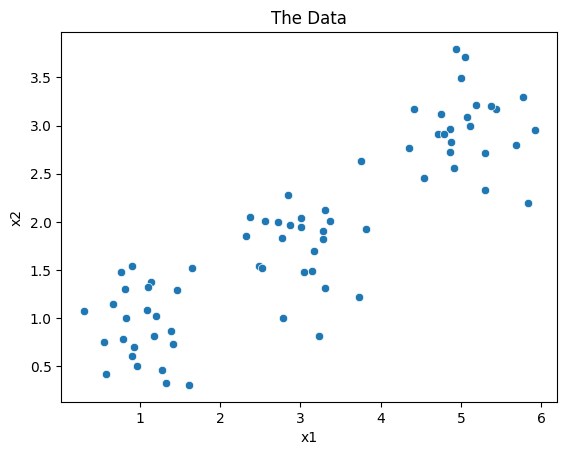

In [ ]:
sns.scatterplot(data=gdf,x='x1',y='x2').set_title('The Data') # Plot the fake data

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


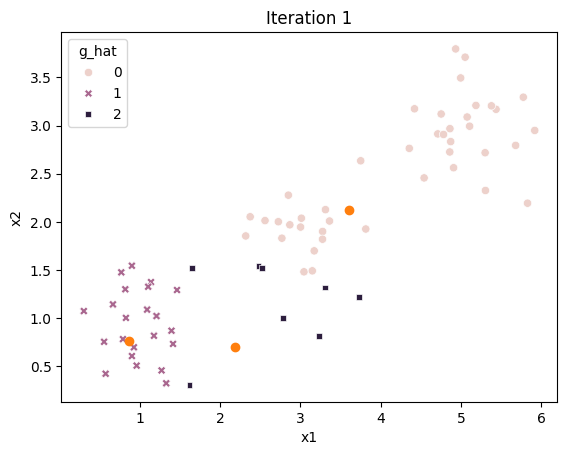

In [7]:
initial_centroids = np.random.randint(low=1,high=24,size=3) # Determine initial centroids
model = KMeans(n_clusters=3, max_iter=1, init = X.iloc[initial_centroids,:],  random_state=0) # Pass centroids and options into the model
model = model.fit(X) # Initialize a kmc model
gdf['g_hat'] = model.predict(X) # Predict values

centers = model.cluster_centers_ # Get the computed centers for the kmc model

# De-normalize the centers, returning them to the scales of the original data, and plot:
min_x1 = min(gdf.loc[:,'x1'])
diff_x1 = max(gdf.loc[:,'x1'])-min_x1
min_x2 = min(gdf.loc[:,'x2'])
diff_x2 = max(gdf.loc[:,'x2'])-min_x2 - min(gdf.loc[:,'x2'])
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='g_hat',style='g_hat').set_title('Iteration 1')
plt.scatter( centers[:,0]*diff_x1+min_x1, centers[:,1]*diff_x2+min_x2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


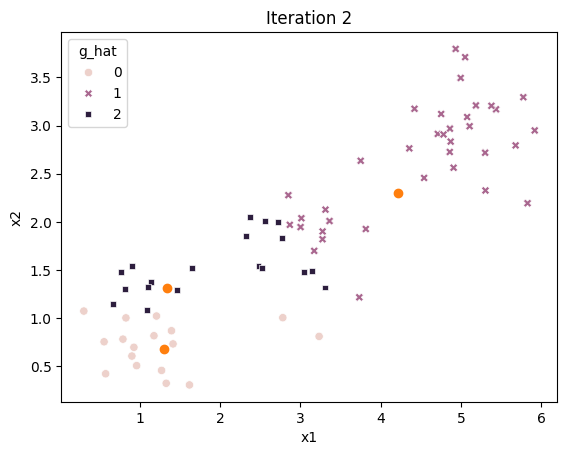

In [8]:
initial_centroids = np.random.randint(low=1,high=24,size=3)
model = KMeans(n_clusters=3, max_iter=2, init = X.iloc[initial_centroids,:],  random_state=0)
model = model.fit(X)
gdf['g_hat'] = model.predict(X)

centers = model.cluster_centers_
min_x1 = min(gdf.loc[:,'x1'])
diff_x1 = max(gdf.loc[:,'x1'])-min_x1
min_x2 = min(gdf.loc[:,'x2'])
diff_x2 = max(gdf.loc[:,'x2'])-min_x2 - min(gdf.loc[:,'x2'])
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='g_hat',style='g_hat').set_title('Iteration 2')
plt.scatter( centers[:,0]*diff_x1+min_x1, centers[:,1]*diff_x2+min_x2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


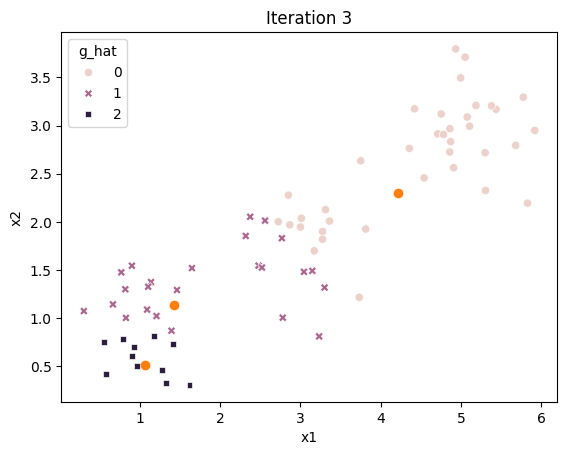

In [9]:
initial_centroids = np.random.randint(low=1,high=24,size=3)
model = KMeans(n_clusters=3, max_iter=3, init = X.iloc[initial_centroids,:],  random_state=0)
model = model.fit(X)
gdf['g_hat'] = model.predict(X)

centers = model.cluster_centers_
min_x1 = min(gdf.loc[:,'x1'])
diff_x1 = max(gdf.loc[:,'x1'])-min_x1
min_x2 = min(gdf.loc[:,'x2'])
diff_x2 = max(gdf.loc[:,'x2'])-min_x2 - min(gdf.loc[:,'x2'])
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='g_hat',style='g_hat').set_title('Iteration 3')
plt.scatter( centers[:,0]*diff_x1+min_x1, centers[:,1]*diff_x2+min_x2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


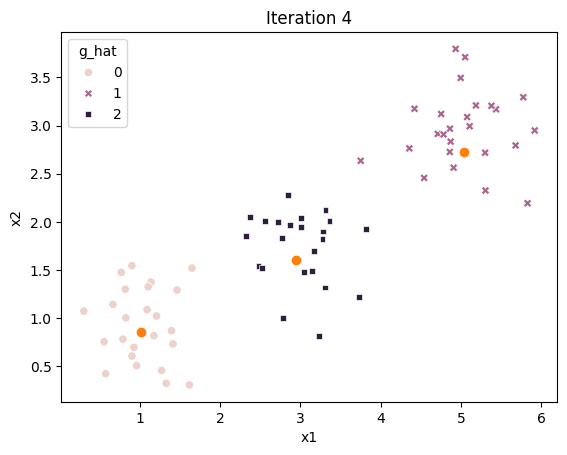

In [10]:
initial_centroids = np.random.randint(low=1,high=24,size=3)
model = KMeans(n_clusters=3, max_iter=4, init = X.iloc[initial_centroids,:],  random_state=0)
model = model.fit(X)
gdf['g_hat'] = model.predict(X)

centers = model.cluster_centers_
min_x1 = min(gdf.loc[:,'x1'])
diff_x1 = max(gdf.loc[:,'x1'])-min_x1
min_x2 = min(gdf.loc[:,'x2'])
diff_x2 = max(gdf.loc[:,'x2'])-min_x2 - min(gdf.loc[:,'x2'])
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='g_hat',style='g_hat').set_title('Iteration 4')
plt.scatter( centers[:,0]*diff_x1+min_x1, centers[:,1]*diff_x2+min_x2)

C:\Users\teren\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\teren\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


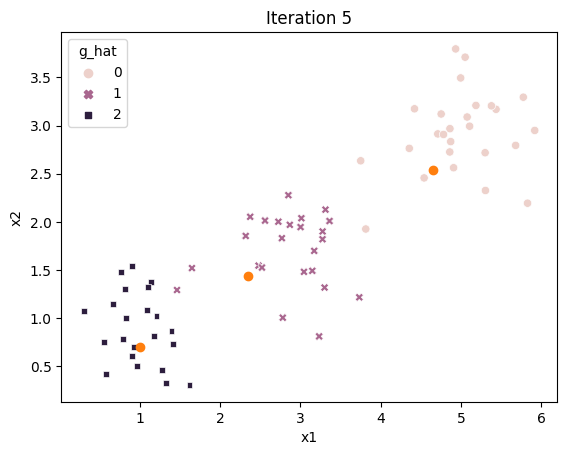

In [ ]:
initial_centroids = np.random.randint(low=1,high=24,size=3)
model = KMeans(n_clusters=3, max_iter=5, init = X.iloc[initial_centroids,:],  random_state=0)
model = model.fit(X)
gdf['g_hat'] = model.predict(X)

centers = model.cluster_centers_
min_x1 = min(gdf.loc[:,'x1'])
diff_x1 = max(gdf.loc[:,'x1'])-min_x1
min_x2 = min(gdf.loc[:,'x2'])
diff_x2 = max(gdf.loc[:,'x2'])-min_x2 - min(gdf.loc[:,'x2'])
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='g_hat',style='g_hat').set_title('Iteration 5')
plt.scatter( centers[:,0]*diff_x1+min_x1, centers[:,1]*diff_x2+min_x2)

C:\Users\teren\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\teren\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


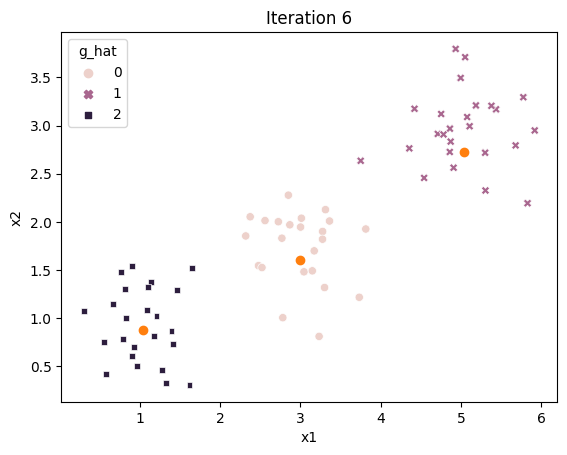

In [ ]:
initial_centroids = np.random.randint(low=1,high=24,size=3)
model = KMeans(n_clusters=3, max_iter=6, init = X.iloc[initial_centroids,:],  random_state=0)
model = model.fit(X)
gdf['g_hat'] = model.predict(X)

centers = model.cluster_centers_
min_x1 = min(gdf.loc[:,'x1'])
diff_x1 = max(gdf.loc[:,'x1'])-min_x1
min_x2 = min(gdf.loc[:,'x2'])
diff_x2 = max(gdf.loc[:,'x2'])-min_x2 - min(gdf.loc[:,'x2'])
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='g_hat',style='g_hat').set_title('Iteration 6')
plt.scatter( centers[:,0]*diff_x1+min_x1, centers[:,1]*diff_x2+min_x2)

C:\Users\teren\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\teren\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


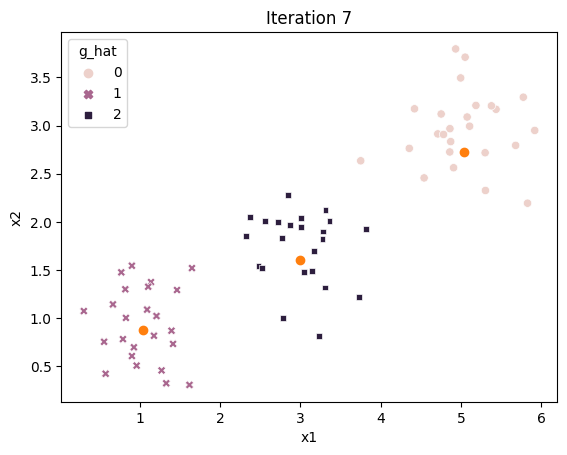

In [ ]:
initial_centroids = np.random.randint(low=1,high=24,size=3)
model = KMeans(n_clusters=3, max_iter=7, init = X.iloc[initial_centroids,:],  random_state=0)
model = model.fit(X)
gdf['g_hat'] = model.predict(X)

centers = model.cluster_centers_
min_x1 = min(gdf.loc[:,'x1'])
diff_x1 = max(gdf.loc[:,'x1'])-min_x1
min_x2 = min(gdf.loc[:,'x2'])
diff_x2 = max(gdf.loc[:,'x2'])-min_x2 - min(gdf.loc[:,'x2'])
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='g_hat',style='g_hat').set_title('Iteration 7')
plt.scatter( centers[:,0]*diff_x1+min_x1, centers[:,1]*diff_x2+min_x2)

## Distance and Scaling
- As with $k$NN, we typically mean Euclidean distance between our new case $\hat{x}$ and each observable $x_i$:
$$ d(\hat{x},x_i) = \sqrt{ \sum_{\ell=1}^N (\hat{x}_i - x_i)^2} $$
- We also need to scale the variables, since the distance metric we're using is relatively arbitrary. We typically use maxmin to rescale a vector $x = (x_1, x_2, ..., x_N)$:
$$ u_i = \dfrac{x - \min(x)}{\max(x)-\min(x)} $$
to ensure all of the dimensions are roughly comparable in magnitude
- There are dozens of variations on these pieces to be more data-driven or reconceptualize "distance" to be more

## SciKit
- There's a canned version of $k$ Means Clustering that can easily be imported:
    - `from sklearn.cluster import KMeans`
- Key arguments with preset values:
    1. `n_clusters = 3`: Number of clusters
    2. `n_init = 10`: How many test runs
    3. `max_iter = 300`: Maximum number of iterations of the $k$MC algorithm; how many times to start from step zero?
    4. `random_state = None`: An initial state for the random number generator for replicability
- To create and fit a $k$MC model, you:
    1. Use `model = KMeans(n_clusters,n_init)` to create the model
    2. Use the `.fit(X)` method to fit the model to the data $X$
    3. Use the `.predict(X_hat)` method to predict cluster values for new cases `X_hat`

In [11]:
from sklearn.cluster import KMeans # Import kmc

def maxmin(x): # Max-min scaler function
    x = (x-min(x))/(max(x)-min(x))
    return x

# Preprocess the data:
X = gdf.loc[ : , ['x1','x2'] ] # Select data to cluster
X = X.apply(maxmin) # Normalize the data

# Create a kmc model:
model = KMeans(n_clusters=3, max_iter=300, n_init = 10, random_state=0)

# Fit the kmc model:
model = model.fit(X)

# Predict values:
gdf['g_hat'] = model.predict(X)

## Example
- With these example data, only one point gets misclassified: The purple x that should be pink.
- This obviously depends on how well the data are "separated": If the groups aren't reasonably visually distinct, the algorithm is unlikely to magically fix that problem (but it might help a lot in higher dimensional situations, where you have trouble visualizing the groups)

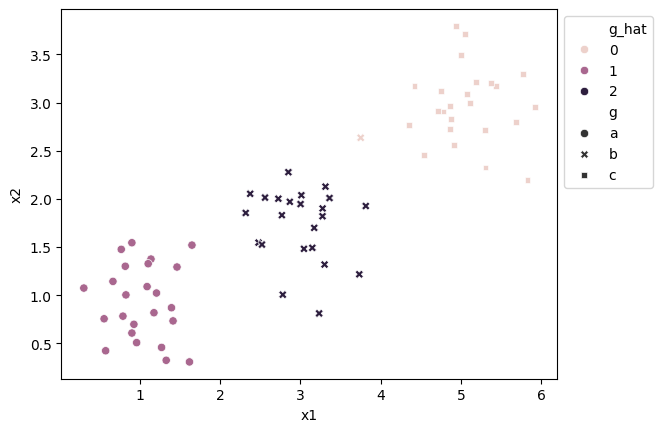

In [12]:
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='g_hat',style='g') # Plot the fake data
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

## Greedy Algorithms
- This is an example of a *greedy algorithm*
- When you assign observations to clusters/centroids, you are ignoring the consequences of changing the centroid averages for overall optimality
- Because you're ignoring the consequences of changing the centroid averages, the optimal assignment might change
- This process might never converge, and just run endlessly, with points meaninglessly wandering back and forth between centroids
- In general, there is no guarantee a stable assignment of observations to centroids exists
- The algorithm is greedy because it is short-sighted about the consequences of its actions, and need not converge to an optimal outcome (some algorithms do achieve optimality, despite being greedy)


## Adjusting $k$
- Typically, you don't want to have "too many clusters"
- For me, "too many clusters" means that many initial guesses give similar results in terms of minimizing error, but the cluster assignments change a lot across these minimizers: "Too many clusters" means that the assignment is somewhat arbitrary, which defeats the point of the algorithm in some sense

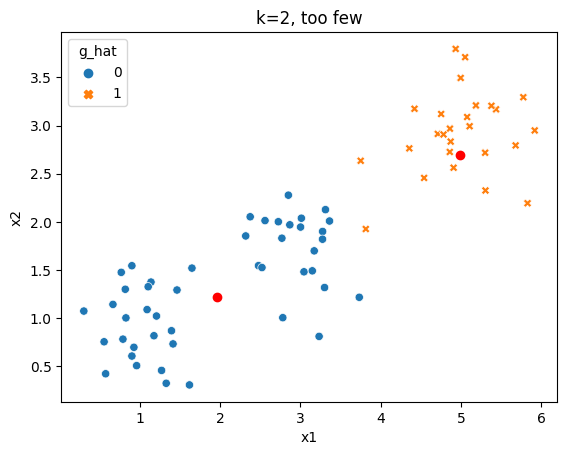

In [ ]:
initial_centroids = np.random.randint(low=1,high=24,size=3)
model = KMeans(n_clusters=2, n_init=10, random_state=0)
model = model.fit(X)
gdf['g_hat'] = model.predict(X)

centers = model.cluster_centers_
min_x1 = min(gdf.loc[:,'x1'])
diff_x1 = max(gdf.loc[:,'x1'])-min_x1
min_x2 = min(gdf.loc[:,'x2'])
diff_x2 = max(gdf.loc[:,'x2'])-min_x2 - min(gdf.loc[:,'x2'])
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='g_hat',style='g_hat').set_title('k=2, too few')
plt.scatter( centers[:,0]*diff_x1+min_x1, centers[:,1]*diff_x2+min_x2, color='r')

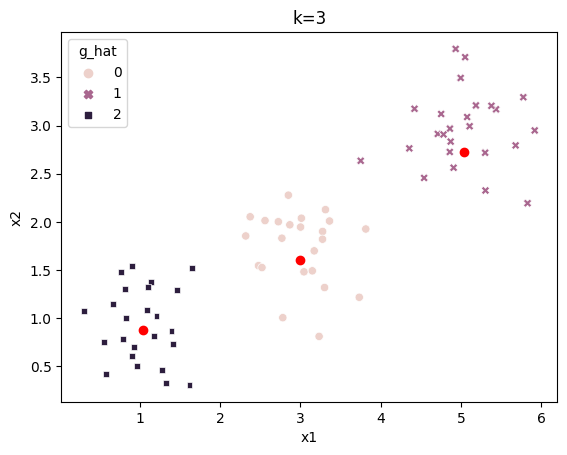

In [ ]:
initial_centroids = np.random.randint(low=1,high=24,size=3)
model = KMeans(n_clusters=3, n_init=10, random_state=0)
model = model.fit(X)
gdf['g_hat'] = model.predict(X)

centers = model.cluster_centers_
min_x1 = min(gdf.loc[:,'x1'])
diff_x1 = max(gdf.loc[:,'x1'])-min_x1
min_x2 = min(gdf.loc[:,'x2'])
diff_x2 = max(gdf.loc[:,'x2'])-min_x2 - min(gdf.loc[:,'x2'])
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='g_hat',style='g_hat').set_title('k=3')
plt.scatter( centers[:,0]*diff_x1+min_x1, centers[:,1]*diff_x2+min_x2, color='r')

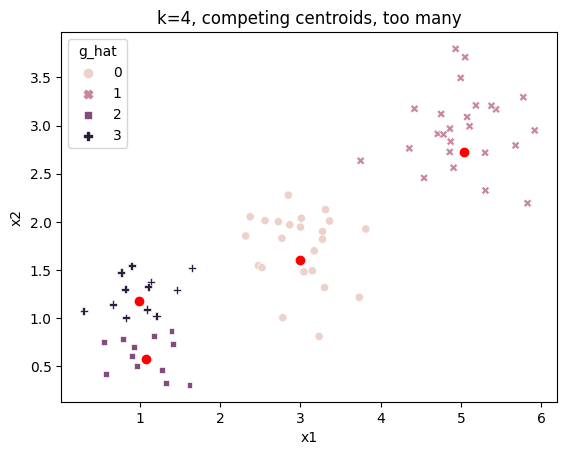

In [ ]:
initial_centroids = np.random.randint(low=1,high=24,size=3)
model = KMeans(n_clusters=4, n_init=10, random_state=0)
model = model.fit(X)
gdf['g_hat'] = model.predict(X)

centers = model.cluster_centers_
min_x1 = min(gdf.loc[:,'x1'])
diff_x1 = max(gdf.loc[:,'x1'])-min_x1
min_x2 = min(gdf.loc[:,'x2'])
diff_x2 = max(gdf.loc[:,'x2'])-min_x2 - min(gdf.loc[:,'x2'])
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='g_hat',style='g_hat').set_title('k=4, competing centroids, too many')
plt.scatter( centers[:,0]*diff_x1+min_x1, centers[:,1]*diff_x2+min_x2, color='r')

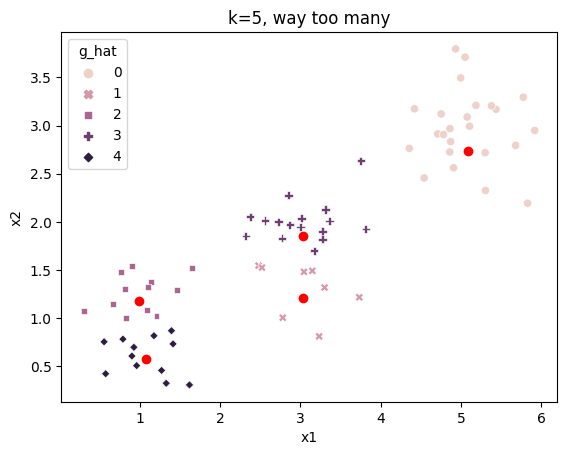

In [ ]:
initial_centroids = np.random.randint(low=1,high=24,size=3)
model = KMeans(n_clusters=5, n_init=10, random_state=1)
model = model.fit(X)
gdf['g_hat'] = model.predict(X)

centers = model.cluster_centers_
min_x1 = min(gdf.loc[:,'x1'])
diff_x1 = max(gdf.loc[:,'x1'])-min_x1
min_x2 = min(gdf.loc[:,'x2'])
diff_x2 = max(gdf.loc[:,'x2'])-min_x2 - min(gdf.loc[:,'x2'])
this_plot = sns.scatterplot(data=gdf,x='x1',y='x2',hue='g_hat',style='g_hat').set_title('k=5, way too many')
plt.scatter( centers[:,0]*diff_x1+min_x1, centers[:,1]*diff_x2+min_x2, color='r')

## Picking $k$
- The number of clusters $k$ is another hyper-parameter: Picking a higher $k$ will break the data up more and reduce the in-sample error, making it tempting to always add more clusters. Here's how most people handle this:
    1. For a range of reasonable values of $k$, compute the optimal centroids and the sum of squared error
    2. Create a **scree plot** that plots SSE as a function of $k$
    3. Pick a $k$ that strikes a balance between reducing the error but introducing too many clusters (an "elbow point"): The reduction in SSE of going from $k-1$ to $k$ clusters is much larger than going from $k$ to $k+1$ clusters

## Sum of Squared Error
- Fix $k$, and focus on the solution to the clustering problem
- Every cluster $j$ has a centroid $c_j$, and the distance from each observation $x_i$ to the centroid to which it is assigned is $d(x_i,c_j)$
- The *within cluster squared error* is
$$
W_j = \sum_{\text{All observations } i \text{ in cluster } j} d(x_i,c_j)^2,
$$
and the *sum of squared error* (SSE) is
$$
\sum_{\text{All clusters j}} W_j = \sum_{\text{All clusters j}} \quad \sum_{\text{All observations } i \text{ in cluster } j} d(x_i,c_j)^2
$$
- This is a traditional metric of how well the model "fits" the data we'll come back to frequently
- In principle, $k$MC is trying to minimize this, but it's a greedy algorithm, so doesn't always achieve the global minimum SSE
- In scikit, this is the  `.inertia_` attribute of a fitted model.
    - Dot what? Yeah, I know... I didn't pick it...

## The Scree Plot
- If we plot $SSE(k)$ against the number of clusters $k$, we can see how the addition or subtraction of a cluster affects this measure of overall fit
- This is called a **scree plot**, and we can use it to decide on a particular number of clusters $k$

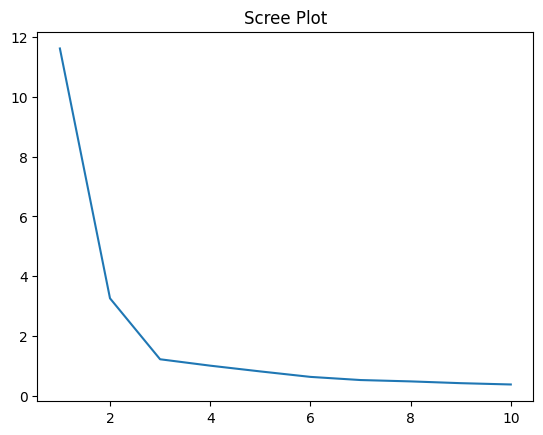

In [ ]:
from sklearn.cluster import KMeans # Import kmc

def maxmin(x): # Max-min scaler function
    x = (x-min(x))/(max(x)-min(x))
    return x

# Preprocess the data:
X = gdf.loc[ : , ['x1','x2'] ] # Select data to cluster
X = X.apply(maxmin) # Normalize the data

# Create a scree plot:
k_bar = 10
k_grid = np.arange(1,k_bar+1) # The range of k's to consider
SSE = np.zeros(k_bar) # We'll store the training error here
for k in range(k_bar): # For indices from 0 to k_bar-1
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0) # Create a model for k
    model = model.fit(X) # Fit the emodel
    SSE[k] = model.inertia_ # Record the sum of squared error for k in the SSE vector

scree_plot = sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot') # Create scree plot

## Elbows
- To decide on an optimal $k^*$, people look for a spot where the reduction in $SSE$ of going from $k-1$ to $k$ drops significantly compared from $k$ to $k+1$
- This means the *marginal benefit* of an additional cluster is small, and increasing $k$ further is probably not really improving the fit
- If there's no elbow, either
    1. There aren't really any discrete clusters, and you're approximating a continuous trend with the groups
    2. Maybe there are discrete clusters, but perhaps there are more data-driven approaches to picking $k$ that could be used
- This feels very subjective, and there are other, more quantitative approaches to this (e.g. silhouette, gap)

## Loose Ends
- Clustering in many dimensions (say, greater than 5) is risky: When the number of dimensions gets larger, many dimensions probably contain similar information, and the redundant information gets over-weighted in the algorithm
    - In high dimensions, you'll want to use something called **Principal Components Analysis** to remove the common information from the features
- There are other versions (agglomerative/hieararchical, spectral, dbscan, Mahalanobis) that fix various shortcomings of $k$MC, but they are typically much more complex and computationally expensive
- Clustering is usually a mean to an end: The clustering is to push the data to reveal some latent group structure, and then that latent group structure enters into some other analysis

## Examples
- Before we get started on examples, the examples with $k$MC often dissappoint me because I am expecting too much
    - Congressional Fundraising
    - Military Spending by Nation
    - Electricity Access
    - Patents by Country
    - Crime Statistics by State
    - International mental health